In [39]:
##libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil

from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [2]:
!nvidia-smi

Fri Jan 16 13:05:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install kaggle

In [ ]:
#kaggle_env=json.load(open('kaggle.json'))

In [ ]:
##virtual env for kaggle credential
os.environ['KAGGLE_USERNAME']=kaggle_env['username']
os.environ['KAGGLE_KEY']=kaggle_env['key']

In [ ]:
##link of data
#https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

In [ ]:
##to download the data from kaggle directory
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 62% 136M/219M [00:00<00:00, 1.43GB/s]
100% 219M/219M [00:00<00:00, 918MB/s] 


In [10]:
!ls

kaggle.json  rice-image-dataset.zip  sample_data


In [ ]:
##data needs to unzip before it is used, because it is in the form of zip file
with ZipFile('rice-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [13]:
## CONSTANTS
RAW_DIR='data/Rice_Image_Dataset'
BAD_DIR='data/cor_data'
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 16
EPOCHS = 10
SEED=42
CHANNELS=3

In [14]:
# ## CONSTANTS
# RAW_DIR='data/raw'
# BAD_DIR='data/cor_data'
# IMG_HEIGHT = 180
# IMG_WIDTH = 180
# BATCH_SIZE = 64
# EPOCHS = 10
# SEED=42
# CHANNELS=3


In [15]:
## load dataset and check the corrupted images if exist and remove them

def check_corrupted_images(raw_data_dir, corrupt_dir, img_height, img_width):
    ##creat the directory to store corrupted images
    os.makedirs(corrupt_dir, exist_ok=True)

    ##walk through the raw data directory
    for cur_dir, dirs, files in os.walk(raw_data_dir):
        ##iterate through each files encountered on each directory
        for file in files:
            ##process only images which has correct extensions
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue
            ##construct the full file path
            file_path = os.path.join(cur_dir, file)

            ##considering files are initially not corrupted
            corrupted=False

            ##PIL checks
            # This catches header corruption and truncated files
            try:
                with Image.open(file_path) as img_file:
                    img_file.verify()
                # Re-open the image to fully load pixel data
                # verify() does not load pixels, so this step is required
                with Image.open(file_path) as img:
                    img.load()
            except Exception:
                # If any Pillow operation fails, mark the image as corrupted
                corrupted=True

            ##TensorFlow check
            #this code ensures the compatibility of the image with Tensorflow
            if not corrupted:
                try:
                    ##read the image file
                    img_raw = tf.io.read_file(file_path)
                    ##decode the image file, expand_animations=False prevents GIF-related issues
                    img_decoded = tf.image.decode_image(img_raw, expand_animations=False)
                    ##resize the image to expected dimensions
                    img_resized = tf.image.resize(img_decoded, (img_height, img_width))
                    ##If the image is corrupted, this code crashes
                    _= tf.cast(img_resized, tf.uint8)
                except Exception:
                    ##If any TensorFlow operation fails, mark the image as corrupted
                    corrupted=True

            if corrupted:
                shutil.move(file_path, os.path.join(corrupt_dir, file))
                print(f'Moving the corrupted image: {file_path}')


In [16]:
##checking the corrupted images
# check_corrupted_images(RAW_DIR,BAD_DIR,IMG_HEIGHT,IMG_WIDTH)

In [17]:
##loading data into working directory
raw_data = tf.keras.preprocessing.image_dataset_from_directory(
    RAW_DIR,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 75000 files belonging to 5 classes.


In [18]:
##class names
class_names = raw_data.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [19]:
##total number of class present in the dataset
N_class=len(class_names)
N_class

5

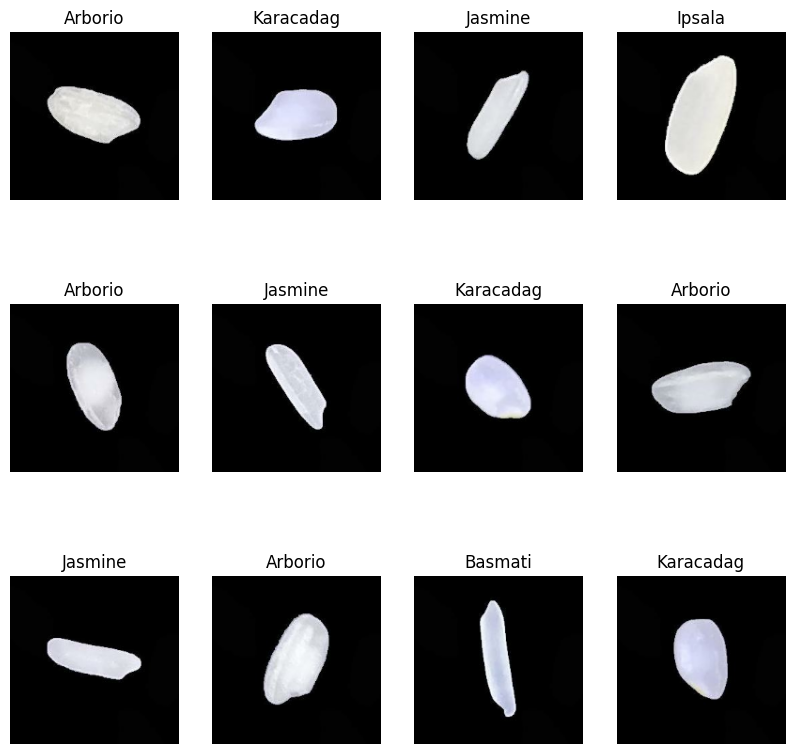

In [20]:
##display some images from the dataset
plt.figure(figsize=(10,10))
for image, label in raw_data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(np.array(image[i]).astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
plt.show()

In [21]:
##data splitting into training, validation and test sets
def data_splitter(raw_dataset,
                  train_split_size=.80,
                  val_split_size=0.10,
                  shuffle=True,
                  shuffle_size=1000):
    ##get the total number of data
    total_number_data= len(raw_dataset)

    if shuffle:
        raw_dataset=raw_dataset.shuffle(shuffle_size, SEED)
    ##calculate the splitted data based on its respective splitting size
    train_data_number=int(train_split_size*total_number_data)
    val_data_number=int(val_split_size*total_number_data)

    ##splitted data
    train=raw_dataset.take(train_data_number)
    val=raw_dataset.skip(train_data_number).take(val_data_number)
    test=raw_dataset.skip(train_data_number).skip(val_data_number)

    return train, val, test

In [22]:
##splitting the dataset
train_ds, val_ds, test_ds = data_splitter(raw_data)

In [23]:
len(train_ds), len(val_ds), len(test_ds)

(3750, 468, 470)

In [24]:
##model

##defining the input shape of the image
input_shapes=(IMG_HEIGHT,IMG_WIDTH, CHANNELS)
model=Sequential([
    ##input layer with image size
    layers.Input(shape=input_shapes),
    ##normalize the image
    layers.Rescaling(1./255),
    ##convolutional layers having 64 kernels with kernel size (3,3) and jump step is 1 step at a time, no padding and relu activation function
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    ##pooling only maximum value from the feature map
    layers.MaxPool2D(),
    ##convolutional layers having 32 kernels with kernel size (3,3) and no padding and relu activation function
    layers.Conv2D(32, (2,2),padding='same', activation='relu'),
    layers.MaxPool2D(),

    ##converting the feature map tensors into the vectors
    layers.Flatten(),

    ##switching off 40% of the nuerons in the hidden layer to avoid the overfitting
    layers.Dropout(0.4),

    ##hidden layers with 16 neurons and relu activation function
    layers.Dense(16, activation='relu'),

    ##output layer number of nueron exactly equal to number of training class with softmax activation function
    layers.Dense(N_class, activation='softmax')
])

In [25]:
##compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
## model summary to check the trainable parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     1,036,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046,917 (3.99 MB)

 Trainable params: 1,046,917 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
##training the model
history=model.fit(
          train_ds,
          epochs=EPOCHS,
          validation_data=val_ds)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 125s 30ms/step - accuracy: 0.9578 - loss: 0.1341 - val_accuracy: 0.9818 - val_loss: 0.0575
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 30ms/step - accuracy: 0.9702 - loss: 0.0946 - val_accuracy: 0.9816 - val_loss: 0.0559
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 30ms/step - accuracy: 0.9661 - loss: 0.1042 - val_accuracy: 0.9748 - val_loss: 0.0764
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 125s 31ms/step - accuracy: 0.9699 - loss: 0.0943 - val_accuracy: 0.9775 - val_loss: 0.0725
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 140s 30ms/step - accuracy: 0.9678 - loss: 0.1010 - val_accuracy: 0.9857 - val_loss: 0.0444
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 30ms/step - accuracy: 0.9724 - loss: 0.0887 - val_accuracy: 0.9700 - val_loss: 0.0892
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 30ms/step - accuracy: 0.9689 - loss: 0.0971 - val_accuracy: 0.9828 - val_loss: 0.0530
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 158s 40ms/step - accuracy: 

In [35]:
##evaluating the model
val_loss, val_accuracy = model.evaluate(val_ds)

468/468 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.9710 - loss: 0.0794


In [38]:
val_loss

0.07984089851379395

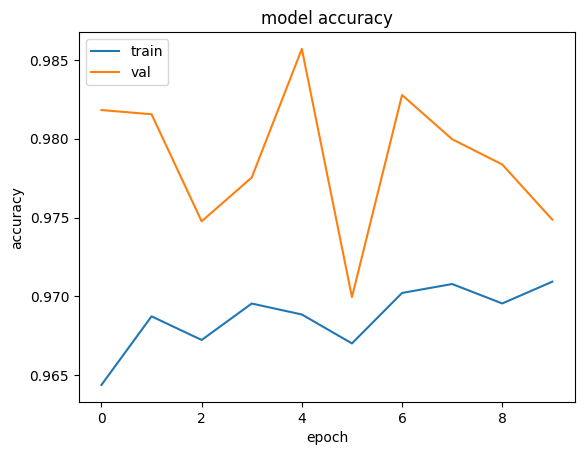

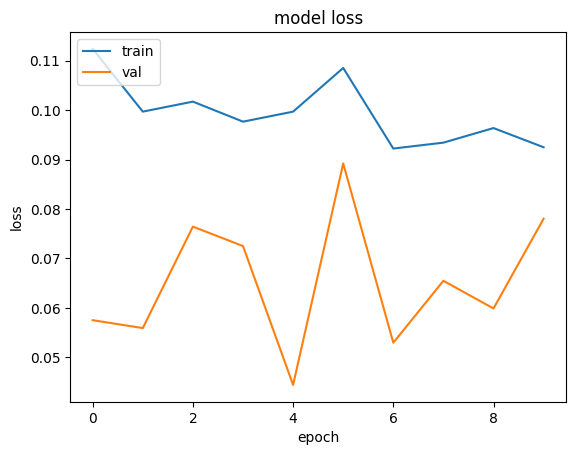

In [40]:
##loss and accuracy of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
##Prediction pipeline
def load_preprocess(image_path, resize_image=(224,224)):
  ##open the image
  img= Image.open(image_path)
  ##resize the image
  re_img=img.resize(resize_image)
  ##convert them into array
  img_array=np.array(re_img)
  ##add batch dimension
  img_batch=np.expand_dims(img_array, axis=0)
  ##normalize the array in between 0-1
  img_norm=img_batch.astype('float32')/255.
  return img_norm

def predict(model, image_path, classes_name):
  ##load and preprocess image
  img_pre=load_preprocess(image_path)
  ##show image
  plt.imshow(img_pre[0])
  plt.axis("off")
  ##predict the class using trained model
  pred_class=model.predict(img_pre)
  ##index of class having maximum probabilities value
  pred_class_max_index=np.argmax(pred_class, axis=1)[0]
  pred_class_name=classes_name[pred_class_max_index]
  return pred_class_name

In [45]:
##converting the class name and index into key value pair,
class_nidx={k:v for k, v in enumerate(class_names)}
class_nidx

{0: 'Arborio', 1: 'Basmati', 2: 'Ipsala', 3: 'Jasmine', 4: 'Karacadag'}

In [46]:
class_nidx

{0: 'Arborio', 1: 'Basmati', 2: 'Ipsala', 3: 'Jasmine', 4: 'Karacadag'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The predicted class is: Jasmine


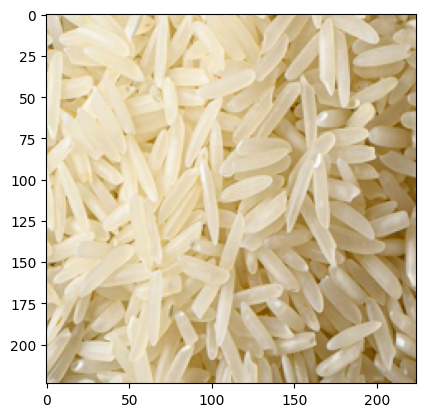

In [54]:
path_image='/content/basmati.jpg'
predict_class_name=predict(model, path_image, class_nidx)
print(f'The predicted class is: {predict_class_name}')